In [1]:
# The code was removed by Watson Studio for sharing.

In [2]:
import pandas as pd
import numpy as np

from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, ElasticNet, Lasso, Ridge, BayesianRidge, LassoLarsIC
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline 
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
import xgboost as xgb

from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

import types
from ibm_botocore.client import Config
import ibm_boto3

import time
import warnings
import types
warnings.filterwarnings('ignore')

%matplotlib inline

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# The code was removed by Watson Studio for sharing.

,Id,MSSubClass,LotFrontage,LotArea,Street,Alley,LandSlope,OverallQual,OverallCond,YearBuilt,...,Heating_OthW.1,Heating_Wall.1,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC
0,1,60,65.0,8450,1,1,0,7,5,2003,...,0,0,0,0,0,1,1,0,0,0
1,2,20,80.0,9600,1,1,0,6,8,1976,...,0,0,0,0,0,1,1,0,0,0
2,3,60,68.0,11250,1,1,0,7,5,2001,...,0,0,0,0,0,1,1,0,0,0
3,4,70,60.0,9550,1,1,0,7,5,1915,...,0,0,0,0,0,1,1,0,0,0
4,5,60,84.0,14260,1,1,0,8,5,2000,...,0,0,0,0,0,1,1,0,0,0


In [4]:
# The code was removed by Watson Studio for sharing.

,Id,MSSubClass,LotFrontage,LotArea,Street,Alley,LandSlope,OverallQual,OverallCond,YearBuilt,...,Heating_GasW.1,Heating_Grav.1,Heating_Wall.1,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed
0,1461,20,80.0,11622,1,1,0,5,6,1961,...,0,0,0,0,1,0,0,1,0,0
1,1462,20,81.0,14267,1,1,0,6,6,1958,...,0,0,0,0,0,0,1,0,0,0
2,1463,60,74.0,13830,1,1,0,5,5,1997,...,0,0,0,0,1,0,0,1,0,0
3,1464,60,78.0,9978,1,1,0,6,6,1998,...,0,0,0,0,0,0,1,1,0,0
4,1465,120,43.0,5005,1,1,0,8,5,1992,...,0,0,0,0,0,0,1,1,0,0


In [5]:
df.shape, df_test.shape

((1458, 231), (1459, 218))

# Linear Regression

In [6]:
X = df.drop(['Id', 'SalePrice'], axis=1)
y = df['SalePrice']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [8]:
print('X_train : ', X_train.shape)
print('X_test : ', X_test.shape)
print('y_train : ', y_train.shape)
print('y_test : ', y_test.shape)

X_train :  (1020, 229)
X_test :  (438, 229)
y_train :  (1020,)
y_test :  (438,)


In [9]:
sc = StandardScaler()

In [10]:
sc.fit_transform(X_train)

array([[-0.86824345, -0.48720324, -0.20627038, ..., -0.04432422,
        -0.20979104,  0.        ],
       [-0.13894755, -0.8634825 , -0.42118407, ..., -0.04432422,
        -0.20979104,  0.        ],
       [ 0.46879903, -0.8634825 ,  0.13307735, ..., -0.04432422,
        -0.20979104,  0.        ],
       ..., 
       [-0.86824345,  0.07721564, -0.18566222, ..., -0.04432422,
        -0.20979104,  0.        ],
       [-0.86824345,  0.03018073,  0.079398  , ..., -0.04432422,
        -0.20979104,  0.        ],
       [ 2.5351374 , -0.41665088, -0.53678605, ..., -0.04432422,
        -0.20979104,  0.        ]])

In [11]:
sc.fit_transform(X_test)

array([[ 2.90852057,  1.40985582,  2.69826127, ...,  0.        ,
        -0.11785113, -0.04783649],
       [-0.88427175,  0.63367937,  0.01414651, ...,  0.        ,
        -0.11785113, -0.04783649],
       [ 0.67746626,  0.17710499, -0.19367021, ...,  0.        ,
        -0.11785113, -0.04783649],
       ..., 
       [ 0.00814997,  0.22276243, -0.27121377, ...,  0.        ,
        -0.11785113, -0.04783649],
       [ 0.2312554 , -0.18815451,  0.15594044, ...,  0.        ,
        -0.11785113, -0.04783649],
       [-0.88427175, -0.18815451, -0.24008557, ...,  0.        ,
        -0.11785113, -0.04783649]])

In [23]:
# Error measure for RMSE scoring.
scorer = make_scorer(mean_squared_error, greater_is_better = False)

In [24]:
def rmse_cv_train(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

In [25]:
def rmse_cv_test(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

In [15]:
lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [16]:
lm.score(X_test, y_test)

0.90437602777772597

RMSE on Training set : 0.126013606296
RMSE on Test set : 0.126013606296


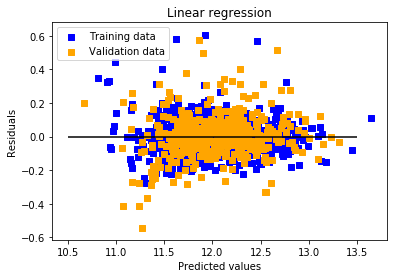

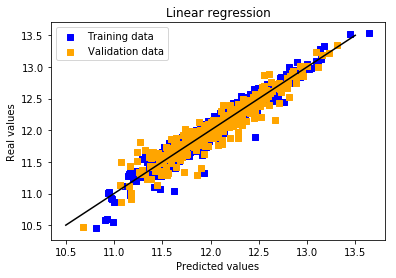

In [17]:
# Look at predictions on training and validation set
print("RMSE on Training set :", rmse_cv_train(lm).mean())
print("RMSE on Test set :", rmse_cv_test(lm).mean())
y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(X_test)

# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "orange", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "black")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "orange", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "black")
plt.show()

# Bagging Regressor

In [16]:
br = BaggingRegressor(LinearRegression(), 
                         n_estimators=50,
                         bootstrap=True)

In [17]:
br.fit(X_train, y_train)

BaggingRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=50, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [18]:
br.score(X_test, y_test)

0.91371170509209976

In [19]:
print("RMSE on Training set :", rmse_cv_train(br).mean())
print("RMSE on Test set :", rmse_cv_test(br).mean())

RMSE on Training set : 0.125466233048
RMSE on Test set : 0.125473855691


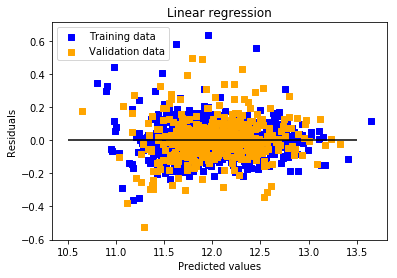

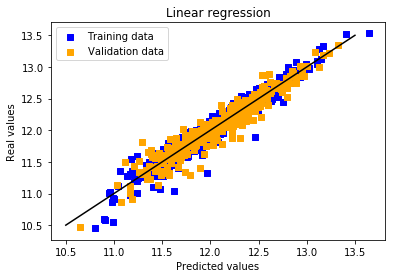

In [20]:
# Look at predictions on training and validation set
# print("RMSE on Training set :", rmse_cv_train(br).mean())
# print("RMSE on Test set :", rmse_cv_test(br).mean())
y_train_br = br.predict(X_train)
y_test_br = br.predict(X_test)

# Plot residuals
plt.scatter(y_train_br, y_train_br - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_br, y_test_br - y_test, c = "orange", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "black")
plt.show()

# Plot predictions
plt.scatter(y_train_br, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_br, y_test, c = "orange", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "black")
plt.show()

# Random Forest

In [39]:
rfr = RandomForestRegressor(bootstrap=True, 
                            n_estimators=100, 
                            n_jobs=1, 
                            random_state=0)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [40]:
rfr.score(X_test, y_test)

0.89390265219786813

Random Forest RMSE on Training set : 0.144516642864
Random Forest RMSE on Test set : 0.144516642864


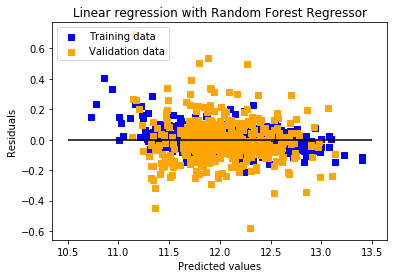

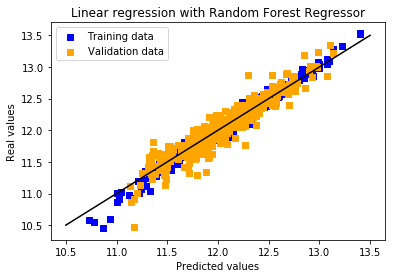

In [39]:
print("Random Forest RMSE on Training set :", rmse_cv_train(rfr).mean())
print("Random Forest RMSE on Test set :", rmse_cv_test(rfr).mean())
y_train_rfr = rfr.predict(X_train)
y_test_rfr = rfr.predict(X_test)

# Plot residuals
plt.scatter(y_train_rfr, y_train_rfr - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rfr, y_test_rfr - y_test, c = "orange", marker = "s", label = "Validation data")
plt.title("Linear regression with Random Forest Regressor")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "black")
plt.show()

# Plot predictions
plt.scatter(y_train_rfr, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rfr, y_test, c = "orange", marker = "s", label = "Validation data")
plt.title("Linear regression with Random Forest Regressor")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "black")
plt.show()

# Lasso

In [17]:
lasso = make_pipeline(RobustScaler(), 
                      Lasso(alpha = 0.0005, 
                            random_state=1))
lasso.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('lasso', Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [18]:
lasso.score(X_test, y_test)

0.92501299820153871

Lasso RMSE on Training set : 0.117189831199
Lasso RMSE on Test set : 0.117189831199


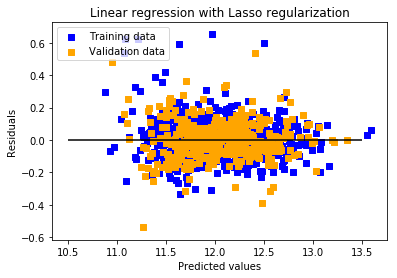

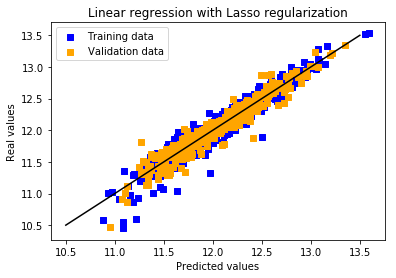

In [20]:
print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())
y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)

# Plot residuals
plt.scatter(y_train_las, y_train_las - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test_las - y_test, c = "orange", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "black")
plt.show()

# Plot predictions
plt.scatter(y_train_las, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test, c = "orange", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "black")
plt.show()

# Ridge

In [21]:
rr = make_pipeline(RobustScaler(), 
                   Ridge(alpha = 0.0005, 
                         random_state=1))
rr.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('ridge', Ridge(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=1, solver='auto', tol=0.001))])

In [22]:
rr.score(X_test, y_test)

0.90440667139157904

Ridge RMSE on Training set : 0.12594391469
Ridge RMSE on Test set : 0.12594391469


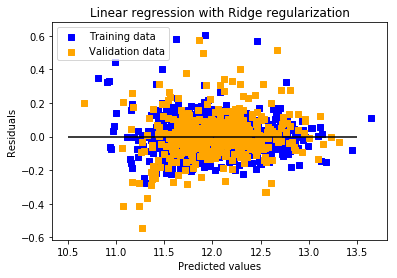

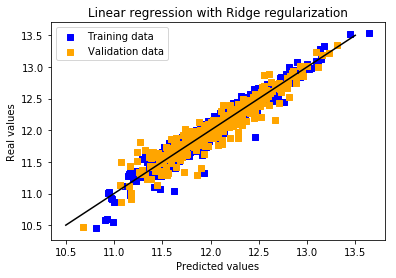

In [23]:
print("Ridge RMSE on Training set :", rmse_cv_train(rr).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(rr).mean())
y_train_rid = rr.predict(X_train)
y_test_rid = rr.predict(X_test)

# Plot residuals
plt.scatter(y_train_rid, y_train_rid - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rid, y_test_rid - y_test, c = "orange", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "black")
plt.show()

# Plot predictions
plt.scatter(y_train_rid, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rid, y_test, c = "orange", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "black")
plt.show()

# Elastic Net

In [19]:
e_net = make_pipeline(RobustScaler(), 
                      ElasticNet(alpha=0.0005, 
                                 random_state=3))
e_net.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('elasticnet', ElasticNet(alpha=0.0005, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=3, selection='cyclic', tol=0.0001, warm_start=False))])

In [20]:
print('Elastic Net Score : ', e_net.score(X_test, y_test))

Elastic Net Score :  0.923212473296


In [21]:
print("Elastic Net RMSE on Training set :", rmse_cv_train(e_net).mean())
print("Elastic Net RMSE on Test set :", rmse_cv_test(e_net).mean())

Elastic Net RMSE on Training set : 0.115869009545
Elastic Net RMSE on Test set : 0.115869009545


Elastic Net RMSE on Training set : 0.115869009545
Elastic Net RMSE on Test set : 0.115869009545


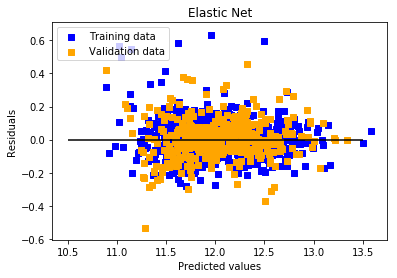

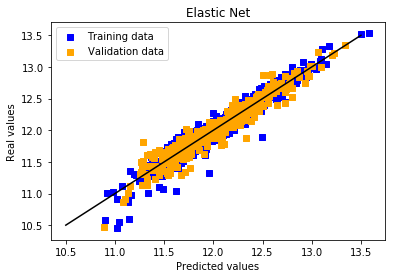

In [32]:
print("Elastic Net RMSE on Training set :", rmse_cv_train(e_net).mean())
print("Elastic Net RMSE on Test set :", rmse_cv_test(e_net).mean())
y_train_rid = e_net.predict(X_train)
y_test_rid = e_net.predict(X_test)

# Plot residuals
plt.scatter(y_train_rid, y_train_rid - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rid, y_test_rid - y_test, c = "orange", marker = "s", label = "Validation data")
plt.title("Elastic Net")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "black")
plt.show()

# Plot predictions
plt.scatter(y_train_rid, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rid, y_test, c = "orange", marker = "s", label = "Validation data")
plt.title("Elastic Net")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "black")
plt.show()

# Gradient Boosting

In [41]:
g_boost = GradientBoostingRegressor(loss='huber', 
                                   learning_rate=0.5, 
                                   n_estimators=3000, 
                                   min_samples_split=10, 
                                   min_samples_leaf=15, 
                                   max_depth=4, 
                                   max_features='sqrt')
g_boost.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.5, loss='huber', max_depth=4,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=15, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=3000,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [42]:
print('Gradient Boosting Score : ', g_boost.score(X_test, y_test))

Gradient Boosting Score :  0.845610136062


In [44]:
print("Gradient Boosting RMSE on Training set :", rmse_cv_train(g_boost).mean())
print("Gradient Boosting RMSE on Test set :", rmse_cv_test(g_boost).mean())

Gradient Boosting RMSE on Training set : 0.149964669717
Gradient Boosting RMSE on Test set : 0.152161045177


In [ ]:
print("Gradient Boosting RMSE on Training set :", rmse_cv_train(g_boost).mean())
print("Gradient Boosting RMSE on Test set :", rmse_cv_test(g_boost).mean())
y_train_rid = g_boost.predict(X_train)
y_test_rid = g_boost.predict(X_test)

# Plot residuals
plt.scatter(y_train_rid, y_train_rid - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rid, y_test_rid - y_test, c = "orange", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "black")
plt.show()

# Plot predictions
plt.scatter(y_train_rid, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rid, y_test, c = "orange", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "black")
plt.show()

# XG Boosting

In [67]:
xg_boost = xgb.XGBRegressor(max_depth=3,
                            learning_rate='0.05', 
                            n_estimators=2200,
                            silent=1,
                            objective='reg:linear',
                            nthread=-1,
                            min_child_weight=1.7817,
                            reg_alpha=0,
                            reg_lambda=0.8571)
xg_boost.fit(X_train, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate='0.05', max_delta_step=0, max_depth=3,
       min_child_weight=1.7817, missing=None, n_estimators=2200,
       nthread=-1, objective='reg:linear', reg_alpha=0, reg_lambda=0.8571,
       scale_pos_weight=1, seed=0, silent=1, subsample=1)

In [68]:
xg_boost.score(X_test, y_test)

0.9130249862173847

In [69]:
print("XG Boosting RMSE on Training set :", rmse_cv_train(g_boost).mean())
print("XG Boosting RMSE on Test set :", rmse_cv_test(g_boost).mean())

XG Boosting RMSE on Training set : 0.146001300828
XG Boosting RMSE on Test set : 0.155976601472


## Run the cleaned test data through the best models and make predictions for submission to Kaggle
- Elastic Net model had the bes RMSE score so I will use that model first followed by the Lasso model which had the second best RMSE.
- My cleaned train data and cleaned test data have a different amount of columns so I need to figure out which columns are different and drop them and run the models again and hope they still come out as good as they did. 

In [6]:
# The code was removed by Watson Studio for sharing.

,Id,MSSubClass,LotFrontage,LotArea,Street,Alley,LandSlope,OverallQual,OverallCond,YearBuilt,...,Heating_OthW.1,Heating_Wall.1,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC
0,1,60,65.0,8450,1,1,0,7,5,2003,...,0,0,0,0,0,1,1,0,0,0
1,2,20,80.0,9600,1,1,0,6,8,1976,...,0,0,0,0,0,1,1,0,0,0
2,3,60,68.0,11250,1,1,0,7,5,2001,...,0,0,0,0,0,1,1,0,0,0
3,4,70,60.0,9550,1,1,0,7,5,1915,...,0,0,0,0,0,1,1,0,0,0
4,5,60,84.0,14260,1,1,0,8,5,2000,...,0,0,0,0,0,1,1,0,0,0


In [7]:
# Find the differnet columns.
df.columns.difference(df_test.columns)

Index(['Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn',
       'Electrical_Mix', 'Exterior1st_ImStucc', 'Exterior1st_Stone',
       'Exterior2nd_Other', 'Heating_GasA', 'Heating_GasA.1', 'Heating_OthW',
       'Heating_OthW.1', 'HouseStyle_2.5Fin', 'MiscFeature_TenC',
       'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'SalePrice',
       'TotalSF', 'Utilities_NoSeWa'],
      dtype='object')

In [8]:
df.drop(['Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn',
       'Electrical_Mix', 'Exterior1st_ImStucc', 'Exterior1st_Stone',
       'Exterior2nd_Other', 'Heating_GasA', 'Heating_GasA.1', 'Heating_OthW',
       'Heating_OthW.1', 'HouseStyle_2.5Fin', 'MiscFeature_TenC',
       'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll',
       'TotalSF', 'Utilities_NoSeWa'], axis=1, inplace=True)

In [9]:
# Check
df.columns.difference(df_test.columns)

Index(['SalePrice'], dtype='object')

In [10]:
df_test.columns.difference(df.columns)

Index(['Exterior1st_Unknown', 'Exterior2nd_Exterior2nd', 'Functional_None',
       'MSZoning_None', 'SaleType_None', 'Utilities_NonPub'],
      dtype='object')

In [11]:
df_test.drop(['Exterior1st_Unknown', 'Exterior2nd_Exterior2nd', 'Functional_None',
       'MSZoning_None', 'SaleType_None', 'Utilities_NonPub'], axis=1, inplace=True)

In [12]:
df_test.columns.difference(df.columns)

Index([], dtype='object')

In [13]:
# Check the shapes of the dataframes.
df.shape, df_test.shape

((1458, 213), (1459, 212))

In [14]:
X = df.drop(['Id', 'SalePrice'], axis=1)
y = df['SalePrice']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [16]:
print('X_train : ', X_train.shape)
print('X_test : ', X_test.shape)
print('y_train : ', y_train.shape)
print('y_test : ', y_test.shape)

X_train :  (1020, 211)
X_test :  (438, 211)
y_train :  (1020,)
y_test :  (438,)


In [17]:
# sc = StandardScaler()

In [18]:
# sc.fit_transform(X_train)

In [19]:
# sc.fit_transform(X_test)

In [20]:
e_net = make_pipeline(RobustScaler(), 
                      ElasticNet(alpha=0.0005, 
                                 random_state=3))
e_net.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('elasticnet', ElasticNet(alpha=0.0005, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=3, selection='cyclic', tol=0.0001, warm_start=False))])

In [21]:
print('Elastic Net Score : ', e_net.score(X_test, y_test))

Elastic Net Score :  0.923728460163


In [26]:
print("Elastic Net RMSE on Training set :", rmse_cv_train(e_net).mean())
print("Elastic Net RMSE on Test set :", rmse_cv_test(e_net).mean())

Elastic Net RMSE on Training set : 0.115829884759
Elastic Net RMSE on Test set : 0.115829884759


#### R2 Score and RMSE came out the same even with less features. 

## Make Predictions on Test Data for Submission

In [27]:
X2 = df_test.drop(columns = ['Id']).values

In [28]:
yhat = e_net.predict(X2)

In [29]:
preds = pd.DataFrame(yhat)

In [30]:
preds.head()

,0
0,11.597428
1,11.953538
2,12.038552
3,12.147045
4,12.144678


In [31]:
preds = preds * 10000

In [32]:
preds.head()

,0
0,115974.282544
1,119535.382315
2,120385.517321
3,121470.448458
4,121446.783200


In [33]:
df_test.shape, preds.shape

((1459, 212), (1459, 1))

In [34]:
predict = pd.concat((df_test['Id'], preds), axis=1)

In [35]:
predict.columns=['Id', 'SalePrice']

In [36]:
predict.head()

,Id,SalePrice
0,1461,115974.282544
1,1462,119535.382315
2,1463,120385.517321
3,1464,121470.448458
4,1465,121446.783200


In [38]:
# Save dataframe as csv file to storage
project.save_data(data=predict.to_csv(index=False),file_name='submission.csv',overwrite=True)

{'asset_id': '3d4728d4-0844-40ce-8815-bd70619734c3',
 'bucket_name': 'housepricesadvancedregressiontech-donotdelete-pr-xspbt29nepkblo',
 'file_name': 'submission.csv',
 'message': 'File saved to project storage.'}